In [1]:
import requests
import json
import pandas as pd
import numpy as np
import sklearn
import matplotlib.pyplot as plt
import folium
from translate import Translator
import matplotlib.cm as cm
import matplotlib.colors as colors

In [2]:
CLIENT_ID = 'XAGWG4QJTV41AQHI1MABTP1Y0IWRMEVMWLSMXRVYNOEEMNAE'
CLIENT_SECRET= 'FTVL5OLLGQ552C5CSJT2JU4BYHAQQ02ZJ4TOSJSJGPH3YYKM'
VERSION=20201115

Lets get the locations of existing billiards cafés and put them in a dataframe.

In [3]:
url = f'https://api.foursquare.com/v2/venues/search?&client_id={CLIENT_ID}&client_secret={CLIENT_SECRET}&v={VERSION}&ll=24.7136,46.6753&categoryId=4bf58dd8d48988d1e3931735&limit=100'
url

'https://api.foursquare.com/v2/venues/search?&client_id=XAGWG4QJTV41AQHI1MABTP1Y0IWRMEVMWLSMXRVYNOEEMNAE&client_secret=FTVL5OLLGQ552C5CSJT2JU4BYHAQQ02ZJ4TOSJSJGPH3YYKM&v=20201115&ll=24.7136,46.6753&categoryId=4bf58dd8d48988d1e3931735&limit=100'

In [4]:
#Getting billiards cafe data
riyadh_data=requests.get(url).json()

In [1]:
# riyadh_data

In [6]:
billiards_data=pd.json_normalize(riyadh_data['response']['venues'])
billiards_data
billiards_data=billiards_data[['id','name','location.lat','location.lng']]
billiards_data.head()

,id,name,location.lat,location.lng
0,500094bfe4b042c51bee94fd,السمر للبلياردو والبلايستيشن,24.708333,46.661671
1,503f6ec9e4b08d67c33747c2,meeting time,24.688202,46.638902
2,56807a07498e89ea767ab3f8,Hour Cafe (ساعة الكيف),24.631776,46.611611
3,52a4944611d2abd78d2538e0,Al Wizarat,24.594221,46.693558
4,5bc10279c0cacb0039d3182e,الثمانية السوداء Poll Hall,24.751186,46.781500


In [7]:
translation=[]
for place in billiards_data['name']:
    translator= Translator(from_lang="arabic",to_lang="english")
    translation.append(translator.translate(place))

In [187]:
billiards_data['name']=translation
billiards_data.head()

,id,name,location.lat,location.lng,Ratings
0,500094bfe4b042c51bee94fd,Al Samar Billiards and Playstation,24.708333,46.661671,7.6
1,503f6ec9e4b08d67c33747c2,meeting time,24.688202,46.638902,0.0
2,56807a07498e89ea767ab3f8,Hour Cafe,24.631776,46.611611,0.0
3,52a4944611d2abd78d2538e0,Al Wizarat,24.594221,46.693558,0.0
4,5bc10279c0cacb0039d3182e,The Black Eight Poll Hall,24.751186,46.781500,0.0


In [9]:
map_billiards = folium.Map(location=[24.7136,46.6753], zoom_start=11)

for latitutde, longitude, label in zip(billiards_data['location.lat'], billiards_data['location.lng'], billiards_data['name']):
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [latitutde, longitude],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_billiards)  
map_billiards

**Lets add the ratings each venue to the dataframe**

In [10]:
VENUE_ID=[billiards_data['id'][i] for i in range(len(billiards_data['id']))]
url_visits=[]
for i in range(len(VENUE_ID)):
    url_visits.append(f'https://api.foursquare.com/v2/venues/{VENUE_ID[i]}/?&client_id={CLIENT_ID}&client_secret={CLIENT_SECRET}&v={VERSION}&limit=50')
# url_visits

**The limit for this url is 50 because that is the number of premium calls we am allowed to make, plus we are lucky in the fact that there is exactly 50 rows in our dataframe.**

In [11]:
jsons = []
for link in url_visits:
    jsons.append(requests.get(link).json())


In [2]:
# jsons

In [13]:
# SAVING FOLDERS ONTO HARDRIVE INCASE WE RUN OUT OF PREMIUM CALLS
# with open('ratings json', 'w') as copy:
#     for i in range(len(jsons)):
#         jsons_unlisted=json.dumps(jsons[i])
#         copy.write(jsons_unlisted)

In [14]:
# Getting the ratings
ratings=[]
for i in range(len(jsons)):
    try:
        ratings.append(jsons[i]['response']['venue']['rating'])
    except KeyError:
        ratings.append(0)

**Attach the rating to the billiards dataframe**

In [16]:
billiards_data['Ratings']=ratings
billiards_data.head()

,id,name,location.lat,location.lng,Ratings
0,500094bfe4b042c51bee94fd,Al Samar Billiards and Playstation,24.708333,46.661671,7.6
1,503f6ec9e4b08d67c33747c2,meeting time,24.688202,46.638902,0.0
2,56807a07498e89ea767ab3f8,Hour Cafe,24.631776,46.611611,0.0
3,52a4944611d2abd78d2538e0,Al Wizarat,24.594221,46.693558,0.0
4,5bc10279c0cacb0039d3182e,The Black Eight Poll Hall,24.751186,46.781500,0.0


In [17]:
billiards_data.Ratings.value_counts()

0.0    38
6.5     2
6.2     1
8.1     1
7.9     1
5.3     1
7.2     1
6.3     1
7.4     1
7.6     1
6.7     1
8.0     1
Name: Ratings, dtype: int64

As we can see most of the venues have no ratings. This could be due to the venue being new or due to very low foot traffic.

**We will now explore areas around the venues and see how they relate to the venues themselves.**

**Lets check for the first location**

In [18]:
lat=billiards_data['location.lat']
lng=billiards_data['location.lng']
url_nearby=[]
for i in range(len(billiards_data['location.lng'])):
    url_nearby.append(f'https://api.foursquare.com/v2/venues/explore?&client_id={CLIENT_ID}&client_secret={CLIENT_SECRET}&v={VERSION}&ll={lat[i]},{lng[i]}')
# url_nearby

In [19]:
nearby_venues=[]
for i in range(len(url_nearby)):
    nearby_venues.append(requests.get(url_nearby[i]).json())

In [3]:
# nearby_venues

In [21]:
for i in range(30):
    print(nearby_venues[0]['response']['groups'][0]['items'][i]['venue']['categories'][0]['name'])

Donut Shop
Spa
Pharmacy
Gym
Chinese Restaurant
Juice Bar
Ice Cream Shop
Jewelry Store
Juice Bar
Lounge
Gym
Coffee Shop
Coffee Shop
Donut Shop
Breakfast Spot
Business Service
Coffee Shop
Public Art
Dessert Shop
Tourist Information Center
Bridal Shop
Pharmacy
Gift Shop
Pool Hall
Dessert Shop
Food Truck
Nail Salon
Art Gallery
Shawarma Place
Breakfast Spot


In [22]:
venues={}
for name in billiards_data['name']:
    venues.update({name:{}})
for i in range(len(billiards_data['name'])):
        outer = nearby_venues[i]['response']['groups'][0]['items'] 
        for j in range(len(outer)):
            temp=outer[j]['venue']['categories'][0]['name']
            if temp in venues[billiards_data['name'][i]]:
                venues[billiards_data['name'][i]].update({temp: venues[billiards_data['name'][i]][temp]+1})
            else:
                venues[billiards_data['name'][i]].update({temp:1})

            


**Putting it into a dataframe:**

In [24]:
df_nearbyVenues=pd.DataFrame(venues).T
df_nearbyVenues=df_nearbyVenues.fillna(0,axis=1)
df_nearbyVenues.insert(0, 'Ratings', ratings)

In [25]:
df_nearbyVenues.index=billiards_data['name']

In [26]:
df_nearbyVenues.head()

,Ratings,Donut Shop,Spa,Pharmacy,Gym,Chinese Restaurant,Juice Bar,Ice Cream Shop,Jewelry Store,Lounge,...,Street Food Gathering,Theater,Theme Restaurant,Multiplex,Optical Shop,Auto Workshop,Cafeteria,Video Store,Lingerie Store,Egyptian Restaurant
name,,,,,,,,,,,,,,,,,,,,,
Al Samar Billiards and Playstation,7.6,2.0,1.0,2.0,2.0,1.0,2.0,1.0,1.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
meeting time,0.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Hour Cafe,0.0,1.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Al Wizarat,0.0,2.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
The Black Eight Poll Hall,0.0,1.0,1.0,3.0,0.0,0.0,1.0,2.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


## Clustering the dataset 

In [27]:
from sklearn.cluster import KMeans

In [129]:
# Finding best number of clusters using the elbow method
clusters=[]
SSE=[]
for i in range(2,10):
    km=KMeans(n_clusters=i, random_state=123)
    km.fit(df_nearbyVenues.drop('Ratings',1))
    clusters.append(i)
    SSE.append(km.inertia_)
print(clusters)
print(SSE)

[2, 3, 4, 5, 6, 7, 8, 9]
[1627.7916666666672, 1372.9038112522685, 1268.7493354598614, 1162.90695970696, 1080.5216783216786, 1041.5, 983.1380952380954, 931.0611111111108]


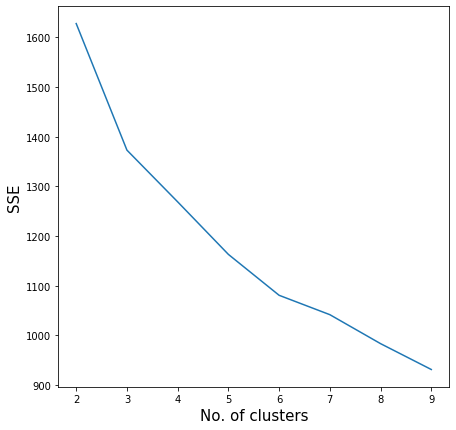

In [135]:
plt.figure(figsize=(7,7))
plt.plot(clusters,SSE)
plt.xlabel('No. of clusters', fontsize=15)
plt.ylabel('SSE', fontsize=15)
plt.show()

**Steep turn occurs at 6 so we use 6 clusters.**

In [152]:
km=KMeans(n_clusters=6, random_state=123)
km.fit(df_nearbyVenues.drop('Ratings',1))

KMeans(n_clusters=6, random_state=123)

In [173]:
km.labels_

array([2, 3, 4, 4, 3, 1, 0, 0, 2, 0, 0, 4, 1, 4, 3, 2, 2, 0, 4, 2, 4, 4,
       1, 3, 2, 5, 3, 2, 4, 3, 5, 0, 2, 3, 2, 3, 4, 2, 3, 1, 4, 2, 1, 3,
       4, 3, 2, 0, 2, 0])

In [156]:
# df_nearbyVenues.insert(0,'Cluster Labels', km.labels_)
df_nearbyVenues['Cluster Labels']=km.labels_

In [1]:
df_nearbyVenues.head()

NameError: name 'df_nearbyVenues' is not defined

In [158]:
# create map
map_clusters = folium.Map(location=[24.7136,46.6753], zoom_start=11)

# set color scheme for the clusters
x = np.arange(5)
ys = [i + x + (i*x)**2 for i in range(6)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, long, label, cluster in zip(billiards_data['location.lat'],billiards_data['location.lng'], billiards_data['name'], df_nearbyVenues['Cluster Labels']):
    label = folium.Popup(str(label) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, long],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters

### Cluster 0

In [159]:
df_nearbyVenues.loc[df_nearbyVenues['Cluster Labels']==0]

,Cluster Labels,Ratings,Donut Shop,Spa,Pharmacy,Gym,Chinese Restaurant,Juice Bar,Ice Cream Shop,Jewelry Store,...,Street Food Gathering,Theater,Theme Restaurant,Multiplex,Optical Shop,Auto Workshop,Cafeteria,Video Store,Lingerie Store,Egyptian Restaurant
name,,,,,,,,,,,,,,,,,,,,,
Blessed Shed,0,0.0,1.0,0.0,0.0,0.0,0.0,3.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Super touch (billiards) and (cafe),0,0.0,1.0,0.0,0.0,0.0,0.0,2.0,2.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Black Ball Champions Pool Hall,0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Celebrity Billiards,0,0.0,3.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
billards rawdah,0,0.0,0.0,0.0,1.0,1.0,0.0,1.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Stars pool hall,0,0.0,0.0,0.0,1.0,1.0,0.0,1.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Champions of Black Ball,0,0.0,2.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
emperor&#39;s billiards,0,0.0,3.0,0.0,0.0,0.0,0.0,2.0,2.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


### Cluster 1

In [160]:
df_nearbyVenues.loc[df_nearbyVenues['Cluster Labels']==1]

,Cluster Labels,Ratings,Donut Shop,Spa,Pharmacy,Gym,Chinese Restaurant,Juice Bar,Ice Cream Shop,Jewelry Store,...,Street Food Gathering,Theater,Theme Restaurant,Multiplex,Optical Shop,Auto Workshop,Cafeteria,Video Store,Lingerie Store,Egyptian Restaurant
name,,,,,,,,,,,,,,,,,,,,,
Elite Time Billiards,1,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,2.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Elite Center for Billiards and Snooker,1,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,2.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
North Billiards,1,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,2.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
North Center for Snooker and Billiards,1,6.7,1.0,0.0,0.0,0.0,0.0,0.0,1.0,2.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
fitness time,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,3.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0


### Cluster 2

In [161]:
df_nearbyVenues.loc[df_nearbyVenues['Cluster Labels']==2]

,Cluster Labels,Ratings,Donut Shop,Spa,Pharmacy,Gym,Chinese Restaurant,Juice Bar,Ice Cream Shop,Jewelry Store,...,Street Food Gathering,Theater,Theme Restaurant,Multiplex,Optical Shop,Auto Workshop,Cafeteria,Video Store,Lingerie Store,Egyptian Restaurant
name,,,,,,,,,,,,,,,,,,,,,
Al Samar Billiards and Playstation,2,7.6,2.0,1.0,2.0,2.0,1.0,2.0,1.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Young imagination,2,0.0,2.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Snooker - Billiards Billiards,2,7.2,3.0,0.0,1.0,2.0,0.0,1.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Fal - Fall Sports Center,2,5.3,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Final Shoot (Final Shoot for Bowling and Billiards),2,7.4,2.0,1.0,1.0,1.0,0.0,2.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Salah Al-Ramal Billiards,2,0.0,3.0,0.0,0.0,1.0,0.0,0.0,2.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
"Champagne, subito!",2,0.0,1.0,0.0,1.0,0.0,0.0,2.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Billiards,2,0.0,2.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Snooker Cafe,2,6.2,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


### Cluster 3

In [162]:
df_nearbyVenues.loc[df_nearbyVenues['Cluster Labels']==3]

,Cluster Labels,Ratings,Donut Shop,Spa,Pharmacy,Gym,Chinese Restaurant,Juice Bar,Ice Cream Shop,Jewelry Store,...,Street Food Gathering,Theater,Theme Restaurant,Multiplex,Optical Shop,Auto Workshop,Cafeteria,Video Store,Lingerie Store,Egyptian Restaurant
name,,,,,,,,,,,,,,,,,,,,,
meeting time,3,0.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
The Black Eight Poll Hall,3,0.0,1.0,1.0,3.0,0.0,0.0,1.0,2.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Omar&#39;s Pool,3,0.0,2.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
A basket of billiard stars,3,0.0,4.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
BeautyLoungeGym,3,0.0,1.0,0.0,2.0,0.0,0.0,1.0,4.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Nujoom El Hout billiards lounge,3,0.0,1.0,0.0,1.0,0.0,0.0,1.0,2.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Billiards and tennis,3,0.0,4.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Black 8,3,6.5,3.0,0.0,0.0,0.0,0.0,2.0,1.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Star Zone 2 for Billiards,3,7.9,2.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0


### Cluster 4

In [163]:
df_nearbyVenues.loc[df_nearbyVenues['Cluster Labels']==4]

,Cluster Labels,Ratings,Donut Shop,Spa,Pharmacy,Gym,Chinese Restaurant,Juice Bar,Ice Cream Shop,Jewelry Store,...,Street Food Gathering,Theater,Theme Restaurant,Multiplex,Optical Shop,Auto Workshop,Cafeteria,Video Store,Lingerie Store,Egyptian Restaurant
name,,,,,,,,,,,,,,,,,,,,,
Hour Cafe,4,0.0,1.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Al Wizarat,4,0.0,2.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Baraish Billard,4,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Coffee Planet,4,6.3,0.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Billiardo & Snooker Club,4,0.0,1.0,0.0,0.0,0.0,0.0,2.0,2.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Labasabad,4,0.0,1.0,0.0,1.0,0.0,0.0,2.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Billiards for the masses,4,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Abdo,4,0.0,2.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Wi-Fi Bowling,4,8.0,0.0,0.0,0.0,0.0,0.0,1.0,2.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


### Cluster 5

In [164]:
df_nearbyVenues.loc[df_nearbyVenues['Cluster Labels']==5]

,Cluster Labels,Ratings,Donut Shop,Spa,Pharmacy,Gym,Chinese Restaurant,Juice Bar,Ice Cream Shop,Jewelry Store,...,Street Food Gathering,Theater,Theme Restaurant,Multiplex,Optical Shop,Auto Workshop,Cafeteria,Video Store,Lingerie Store,Egyptian Restaurant
name,,,,,,,,,,,,,,,,,,,,,
Sands Leisure Lounge,5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
al rimal billiards,5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


### Mean Ratings

In [180]:
df_nearbyVenues.groupby('Cluster Labels').mean()

,Ratings,Donut Shop,Spa,Pharmacy,Gym,Chinese Restaurant,Juice Bar,Ice Cream Shop,Jewelry Store,Lounge,...,Street Food Gathering,Theater,Theme Restaurant,Multiplex,Optical Shop,Auto Workshop,Cafeteria,Video Store,Lingerie Store,Egyptian Restaurant
Cluster Labels,,,,,,,,,,,,,,,,,,,,,
0,0.000000,1.375000,0.000000,0.500000,0.250000,0.000000,1.375000,1.125000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000
1,1.340000,0.800000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,2.200000,0.800000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.2,0.200000
2,3.215385,1.846154,0.230769,0.538462,0.846154,0.076923,0.769231,1.076923,0.076923,0.230769,...,0.076923,0.076923,0.076923,0.076923,0.000000,0.000000,0.076923,0.076923,0.0,0.000000
3,1.309091,2.090909,0.181818,0.818182,0.272727,0.000000,0.818182,1.363636,0.363636,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.090909,0.090909,0.000000,0.000000,0.0,0.090909
4,1.890909,1.090909,0.090909,0.181818,0.181818,0.000000,1.000000,1.090909,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.090909,0.000000,0.000000,0.000000,0.0,0.000000
5,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000


We can see that cluster label 2 has the best overall rating followed by cluster label 4. Lets break down the number of each nearby venue to see why clusters 2 and 4 have higher ratings.

In [185]:
no_venues=[]
for i in range(len(np.unique(km.labels_))):
    df_cluster= df_nearbyVenues.loc[df_nearbyVenues['Cluster Labels']==i]
    df_cluster=df_cluster.iloc[:,2:]
    list1=[]
    for j in range(len(df_cluster.columns)):
        list1.append(df_cluster.iloc[:,j].sum())
    no_venues.append(list1)

In [186]:
df_no_venues=pd.DataFrame(data=no_venues, columns=df_nearbyVenues.iloc[:,2:].columns)
df_no_venues = df_no_venues.T
df_no_venues.columns=['Cluster 0', 'Cluster 1', 'Cluster 2', 'Cluster 3', 'Cluster 4','Cluster 5']
df_no_venues
df_no_venues.sort_values(by='Cluster 2', ascending=False)

,Cluster 0,Cluster 1,Cluster 2,Cluster 3,Cluster 4,Cluster 5
Coffee Shop,15.0,27.0,77.0,33.0,43.0,0.0
Donut Shop,11.0,4.0,24.0,23.0,12.0,0.0
Dessert Shop,20.0,0.0,17.0,9.0,15.0,0.0
Ice Cream Shop,9.0,5.0,14.0,15.0,12.0,0.0
Breakfast Spot,3.0,4.0,14.0,22.0,7.0,0.0
...,...,...,...,...,...,...
Theme Park,2.0,0.0,0.0,0.0,0.0,0.0
Pie Shop,4.0,0.0,0.0,2.0,2.0,0.0
American Restaurant,1.0,0.0,0.0,0.0,0.0,0.0
Electronics Store,1.0,5.0,0.0,3.0,0.0,0.0


From this table we can see that compared to other clusters, cluster 2 and 4 have more desser and coffee shops as compared and less restaraunts and other type of stores as compared to other clusters. This gives an idea that people tend to play billiards before or after going to a cafe/ dessert shop. Thus, we should look to open a billiards area in an area with more coffee shops and dessert shops as well as an area that has less competition and is close to the city so that people can easily access it. Looking at the map for light blue (Cluster 2) and light green (Cluster 4) circles which are close to the city, we see that the area around Al Samar Billiards and Playstation, Snooker Billiards and Snooker Cafe is an ideal area to build the billiards cafe as there is not much competition there.

# Conclusion

The aim of this project was to find a suitable area to open a billiards cafe in Riyadh, Saudi Arabia. The initial plan was the get the visit count from the foursquare API for respective existing billiards cafe and work with that data. Unfortunately, it turned out that only owners have access to that data and so we used the ratings of the respective cafes instead.

The results could be much more accurate as the Riyadh database needs more data and needs to be updated.